## Import data

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\GRZEGORZ\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


<br>

We will use daily Microsoft returns from 2001-today

In [4]:
import yfinance as yf
from datetime import datetime

# Microsoft sotck data
msft = yf.Ticker("MSFT")
ms = msft.history(start="2001-01-01", end=datetime.today().strftime('%Y-%m-%d'))

ms.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-01-02 00:00:00-05:00,13.677950,13.949184,13.290472,13.445463,82413200,0.0,0.0
2001-01-03 00:00:00-05:00,13.387338,15.150360,13.367964,14.859752,135962200,0.0,0.0
2001-01-04 00:00:00-05:00,14.821007,15.654083,14.530399,15.014746,112397000,0.0,0.0
2001-01-05 00:00:00-05:00,15.034123,15.460348,14.743515,15.227861,93414600,0.0,0.0
2001-01-08 00:00:00-05:00,15.169742,15.421602,14.472282,15.169742,79817600,0.0,0.0


In [5]:
ms = ms.iloc[:, :-2]

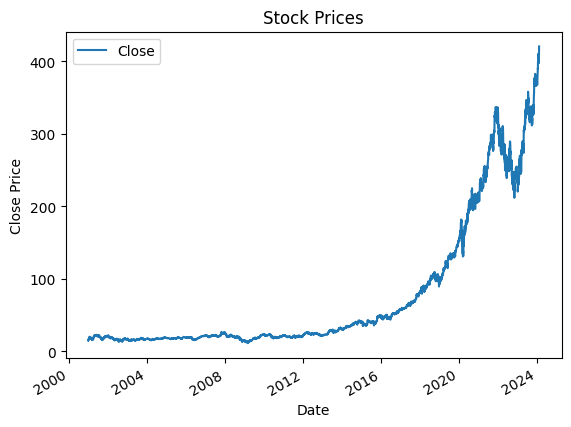

In [14]:
ms.plot( y='Close', kind='line')
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


In [6]:
ms.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5813 entries, 2001-01-02 00:00:00-05:00 to 2024-02-09 00:00:00-05:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5813 non-null   float64
 1   High    5813 non-null   float64
 2   Low     5813 non-null   float64
 3   Close   5813 non-null   float64
 4   Volume  5813 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 272.5 KB


<br>

## Analysis

In our analyses, we will particularly focus on logarithmic rates of return, which are calculated according to the formula: 
$$
\log \left( \frac{P_{t}}{P_{t-1}} \right)
$$

In [7]:
ms['Return'] = 100 * (ms['Close'].pct_change())
ms['Log Return'] = np.log(ms['Close']).diff().mul(100)
ms = ms.dropna()

<br>

### Plots

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot
from statsmodels.tsa.stattools import acf, adfuller, q_stat
from statsmodels.tools import add_constant
#from hurst import compute_Hc

<br>

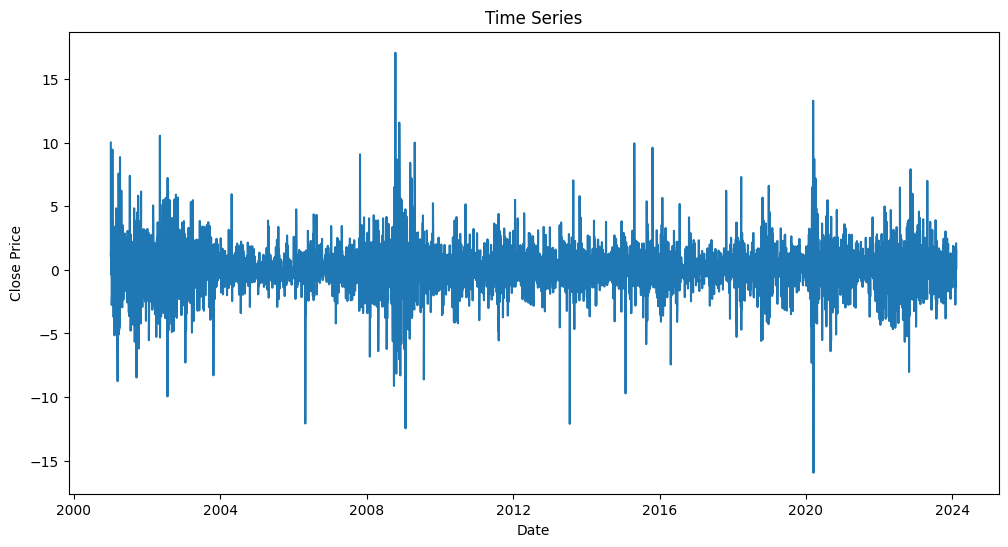

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(ms['Log Return'])
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.show()

As we can see there the time series of  returns is zero mean and the returns displays for some random day very high volatility, meaning that the standard stationarity won't work here.

In [42]:
print(f"Average: {ms['Log Return'].mean()}\nStandard Deviation: {ms['Log Return'].std()}")


Average: 0.05923815571632724
Standard Deviation: 1.8153759694207936


<br>

<Figure size 1200x600 with 0 Axes>

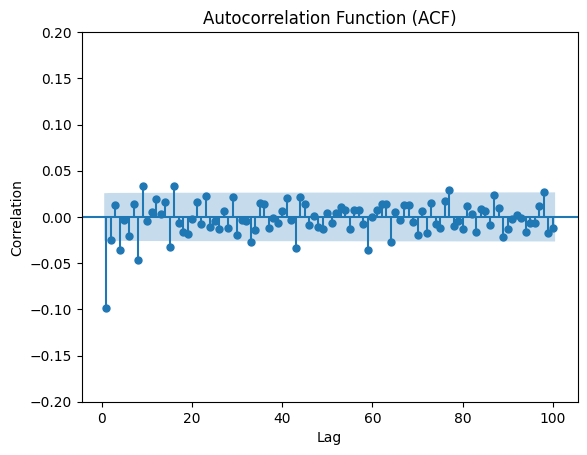

In [28]:
plt.figure(figsize=(12, 6))
plot_acf(x=ms['Log Return'], lags=100, zero=False)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.ylim(-0.2, 0.2)

plt.show()

The autocorrelation function (ACF) is a statistical tool used to measure the correlation between a time series and its lagged values. In the above plot, it is evident that there is a significant spike at a lag of 1, which extends beyond the band of insignificance.

<br>

<Figure size 1200x600 with 0 Axes>

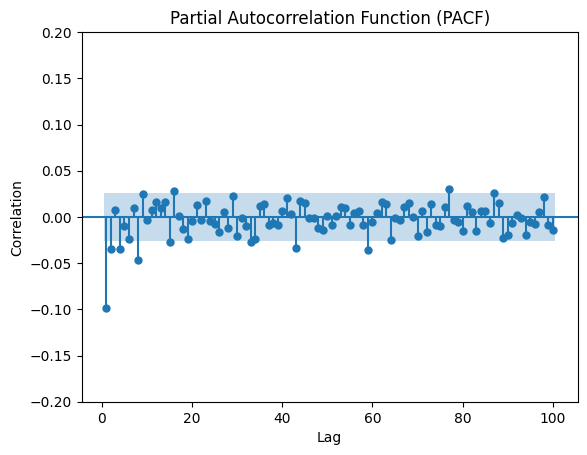

In [32]:
plt.figure(figsize=(12, 6))
plot_pacf(ms['Log Return'], lags=100, zero=False)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.ylim(-0.2, 0.2)

plt.show()

<br>

C:\Users\GRZEGORZ\AppData\Local\Temp\ipykernel_4340\1829477301.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ms['Log Return'], fit=norm, kde=False, hist_kws={"edgecolor": "black"})


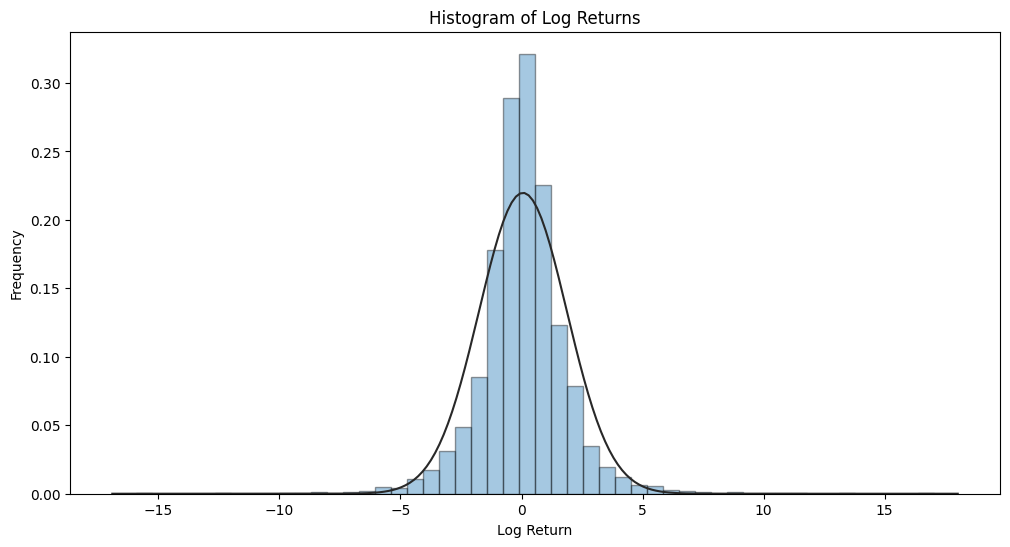

In [51]:
from scipy.stats import norm

plt.figure(figsize=(12, 6))
sns.distplot(ms['Log Return'], fit=norm, kde=False, hist_kws={"edgecolor": "black"})
plt.title('Histogram of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')

plt.show()


In [52]:
from scipy.stats import kurtosis, skew

print("Skewness of Log Return:", skew(ms['Log Return']))
print("Kurtosis of Log Return:", kurtosis(ms['Log Return']))

Skewness of Log Return: 0.029952405583398376
Kurtosis of Log Return: 7.529274438001265


The histogram of logarithmic returns distribution exhibits very fat tails, which is a characteristic feature of financial time series data. Additionally, the majority of values cluster around a mean close to zero, which is another hallmark of financial time series. Moreover, the distribution is leptokurtic, with a kurtosis of 7.53 is significantly higher than 3, which is typical for data following a normal distribution. Based on the chart, we can conclude that logarithmic returns do not follow a normal distribution.

In [54]:
from scipy.stats import jarque_bera

jb_test = jarque_bera(ms['Log Return'])

print("Jarque-Bera test statistic:", jb_test[0])
print("Jarque-Bera p-value:", jb_test[1])

Jarque-Bera test statistic: 13729.290967116782
Jarque-Bera p-value: 0.0


To formally confirm that the logarithmic returns do not follow a normal distribution, we conducted a Jarque-Bera test. The p-value obtained was 0.0, indicating that we reject the null hypothesis in favor of the alternative hypothesis, which states that the logarithmic returns do not follow a normal distribution.

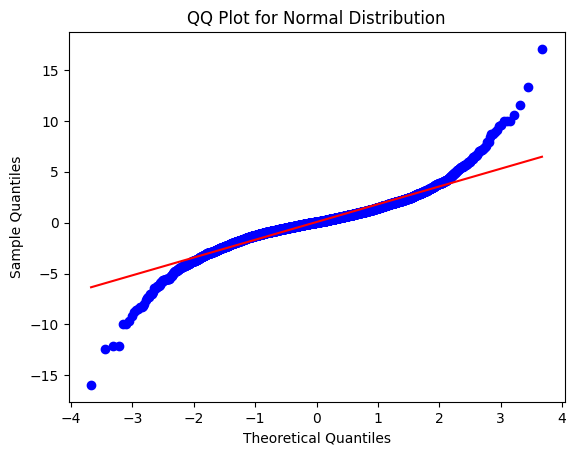

In [59]:
import scipy.stats as stats

stats.probplot(ms['Log Return'], dist="norm", plot=plt)
plt.title('QQ Plot for Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In the QQ plot, the influence of fat tails is evident, providing further confirmation that the logarithmic returns do not follow a normal distribution.

<br>

## GARCH model

\begin{equation}
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2
\end{equation}





In [ ]:
pip install arch

In [70]:
from arch import arch_model

# Specify GARCH model assumptions
garch11_specification = arch_model(ms['Log Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

garch11 = garch11_specification.fit(update_freq = 5)

Iteration:      5,   Func. Count:     38,   Neg. LLF: 10986.22536068767
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10959.791390351671
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10959.791384642245
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


In [71]:
garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Log Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10959.8
Distribution:                  Normal   AIC:                           21927.6
Method:            Maximum Likelihood   BIC:                           21954.3
                                        No. Observations:                 5812
Date:                Tue, Feb 13 2024   Df Residuals:                     5811
Time:                        11:46:42   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0819  1.885e-02      4.345  1.390e-05 [4.496e-02,  0.119]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0683  4.078e-02      1.675  9.391e-02 [-1.162e-02,  0.148]
alpha[1]       0.0725  2.722e-02      2.665  7.710e-03  [1.918e-02,  0.126]
beta[1]        0.9056  3.727e-02     24.297 2.089e-130    [  0.833,  0.979]
===========================================================================

Covariance estimator: robust
"""

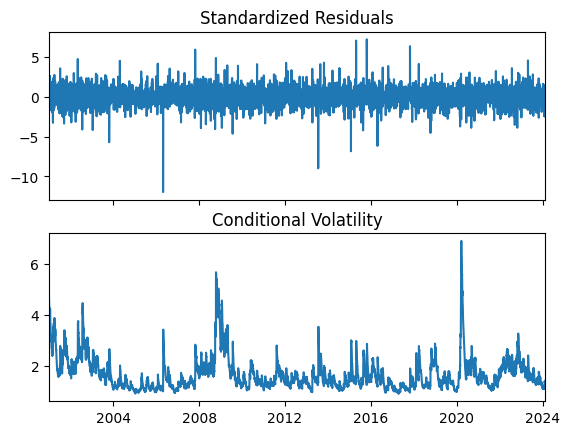

In [74]:
garch11.plot()
plt.show()

<br>

### Forecast using GARCH(1,1)

In [78]:
garch11_forecasts = garch11.forecast(horizon=10, align='origin')
garch11_forecasts.variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2024-02-09 00:00:00-05:00,1.972341,1.997488,2.022084,2.046141,2.069672,2.092688,2.1152,2.13722,2.158757,2.179823


<br>

## GARCH with Student's t-distribution

In [79]:
garch11_std_specification = arch_model(ms['Log Return'], p = 1, q = 1,
                                       mean = 'constant', vol = 'GARCH', dist = 't')

garch11_std = garch11_std_specification.fit(update_freq = 5)

Iteration:      5,   Func. Count:     41,   Neg. LLF: 10633.921152470852
Iteration:     10,   Func. Count:     77,   Neg. LLF: 10588.173466461863
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10588.172234485228
            Iterations: 13
            Function evaluations: 94
            Gradient evaluations: 13


In [80]:
garch11_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -10588.2
Distribution:      Standardized Student's t   AIC:                           21186.3
Method:                  Maximum Likelihood   BIC:                           21219.7
                                              No. Observations:                 5812
Date:                      Tue, Feb 13 2024   Df Residuals:                     5811
Time:                              11:57:33   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0757  1.618e-02      4.679  2.880e-06 [4.399e-02,  0.107]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0342  1.055e-02      3.242  1.188e-03 [1.353e-02,5.490e-02]
alpha[1]       0.0824  1.460e-02      5.643  1.672e-08   [5.378e-02,  0.111]
beta[1]        0.9111  1.530e-02     59.534      0.000     [  0.881,  0.941]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.7700      0.319     14.956  1.422e-50 [  4.145,  5.395]
========================================================================

Covariance estimator: robust
"""